<a href="https://colab.research.google.com/github/huongnd12/sentiment-classification/blob/main/sentiment_classification_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Load data

In [ ]:
# Download training and testing data from Github
!git clone https://github.com/congnghia0609/ntc-scv.git
!unzip /content/ntc-scv/data/data_test.zip -d /content/data
!unzip /content/ntc-scv/data/data_train.zip -d /content/data

In [ ]:
# Read data from files
import os
import pandas as pd
import numpy as np
import time
import torch
from torch.utils.data import DataLoader
from torch import nn
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def load_data_from_path(root_path):
  labels = os.listdir(root_path)
  data = []
  for cls in labels:
    label = 1 if cls == 'pos' else 0
    cls_path = os.path.join(root_path, cls)
    file_list = os.listdir(cls_path)
    for file_name in file_list:
      path = os.path.join(cls_path, file_name)
      with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
      sentence = ' '.join(lines)
      sub_data = {
          'sentence':sentence,
          'label':label
      }
      data.append(sub_data)
      result = pd.DataFrame(data)
  return result

In [ ]:
folder_path = {
    'train':'/content/data/data_train/train',
    'val':'/content/data/data_train/test',
    'test':'/content/data/data_test/test'
}
train_df = load_data_from_path(folder_path['train'])
val_df = load_data_from_path(folder_path['val'])
test_df = load_data_from_path(folder_path['test'])

In [ ]:
print('Category count:')
print('\n')
print('Training set:')
print(train_df['label'].value_counts())
print('\n')
print('Validation set:')
print(val_df['label'].value_counts())
print('\n')
print('Testing set:')
print(test_df['label'].value_counts())

Category count:


Training set:
1    15000
0    15000
Name: label, dtype: int64


Validation set:
1    5000
0    5000
Name: label, dtype: int64


Testing set:
1    5000
0    5000
Name: label, dtype: int64


# 2.Data Preprocessing

## 2.1. Language detection

Keep samples in Vietnamese and remove the others

In [ ]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941173 sha256=7006caabd7f2d84e48b125a26898e669de3c143a0d07d4f55008936060dbda05
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [ ]:
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
  '''
  Return 2 language classified dataframes
  '''
  identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
  not_vi_idx = set()
  THRESHOLD = 0.9
  for idx, row in df.iterrows():
    score = identifier.classify(row['sentence'])
    if score[0] != 'vi' or (score[0] == 'vi' and score[1] < THRESHOLD):
      not_vi_idx.add(idx)
  not_vi_df = df[df.index.isin(not_vi_idx)]
  vi_df = df[~df.index.isin(not_vi_idx)]
  return vi_df, not_vi_df

In [ ]:
train_df_vi, _ = identify_vn(train_df)
val_df_vi, _ = identify_vn(val_df)
test_df_vi, _ = identify_vn(test_df)

In [ ]:
print('Category count of Samples in Vietnamese:')
print('\n')
print('Training set:')
print(train_df_vi['label'].value_counts())
print('\n')
print('Validation set:')
print(val_df_vi['label'].value_counts())
print('\n')
print('Testing set:')
print(test_df_vi['label'].value_counts())

Category count of Samples in Vietnamese:


Training set:
0    14887
1    14849
Name: label, dtype: int64


Validation set:
0    4970
1    4951
Name: label, dtype: int64


Testing set:
0    4966
1    4954
Name: label, dtype: int64


## 2.2. Text Preprocessing

- Remove HTML tags, URL
- Remove punctuations and numbers
- Remove special characters, emojis, emoticons
- Normalize whitespace
- Lowercase

In [ ]:
import re
import string
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def text_preprocessing(text):
  # Remove URL
  url_pattern = re.compile('https?://\S+')
  text = url_pattern.sub('', text)

  # Remove HTML tags
  html_pattern = re.compile('<[^<>]+>')
  text = html_pattern.sub('', text)

  # Remove punctuations and digits
  remove_char = list(string.punctuation + string.digits)
  for char in remove_char:
    if char in text:
      text = text.replace(char, '')

  # Remove emojis and emoticons
  emoj = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U00002500-\U00002BEF"  # chinese char
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U00010000-\U0010ffff"
          u"\u2640-\u2642"
          u"\u2600-\u2B55"
          u"\u200d"
          u"\u23cf"
          u"\u23e9"
          u"\u231a"
          u"\ufe0f"  # dingbats
          u"\u3030"
                        "]+", flags=re.UNICODE)

  text = emoj.sub('', text)

  # Normalize whitespace
  text = ' '.join(text.split())

  # Lowercase
  text = text.lower()

  return text

In [ ]:
train_df_vi['processed_sentence'] = train_df_vi['sentence'].map(text_preprocessing)
val_df_vi['processed_sentence'] = val_df_vi['sentence'].map(text_preprocessing)
test_df_vi['processed_sentence'] = test_df_vi['sentence'].map(text_preprocessing)

# 3.Vectorization

In [ ]:
!pip install -q torchtext==0.16.0

In [ ]:
from torchtext.data.utils import get_tokenizer

# Word-based tokenizer
tokenizer = get_tokenizer('basic_english')

# Create iter dataset
def yield_tokens(sentences, tokenizer):
  for sen in sentences:
    yield tokenizer(sen)

# Build vocabulary
from torchtext.vocab import build_vocab_from_iterator
vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    iterator=yield_tokens(train_df_vi['processed_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<unk>"]
)

vocabulary.set_default_index(vocabulary['<unk>'])

# Convert iter into torchtext dataset
from torchtext.data.functional import to_map_style_dataset
def prepare_dataset(df):
  for idx, row in df.iterrows():
    sentence = row['processed_sentence']
    encoded_sentence = vocabulary(tokenizer(sentence))    # vocabulary(tokenizer('I am the best')) -> [62, 5276, 1083, 3065]
    label = row['label']
    yield encoded_sentence, label

training_dataset = prepare_dataset(train_df_vi)
training_dataset = to_map_style_dataset(training_dataset)

val_dataset = prepare_dataset(val_df_vi)
val_dataset = to_map_style_dataset(val_dataset)

# test_dataset = prepare_dataset(test_df_vi)
# test_dataset = to_map_style_dataset(test_dataset)


In [ ]:
def collate_batch(batch):
  encoded_sentences, labels, offsets = [], [], [0]
  for encoded_sentence, label in batch:
    encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
    encoded_sentences.append(encoded_sentence)
    labels.append(label)
    offsets.append(encoded_sentence.size(0))

  encoded_sentences = torch.cat(encoded_sentences)
  labels = torch.tensor(labels, dtype=torch.int64)
  offsets = torch.tensor(offsets[:-1], dtype=torch.int64).cumsum(dim=0)

  return encoded_sentences.to(device), labels.to(device), offsets.to(device)


batch_size = 128
train_loader = DataLoader(
    dataset=training_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    collate_fn=collate_batch
)

# test_loader = DataLoader(
#     dataset=test_dataset,
#     batch_size=batch_size,
#     collate_fn=collate_batch
# )

# 4.Modeling

The model includes 2 layers: EmbeddingBag layer and Linear layer

In [ ]:
class TextClassificationModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, num_class):
    super(TextClassificationModel, self).__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
    self.linear = nn.Linear(embed_dim, num_class)
    self.init_weights()

  def init_weights(self):
    init_range = 0.5
    self.linear.weight.data.uniform_(-init_range, init_range)
    self.linear.bias.data.zero_()
    self.embedding.weight.data.uniform_(-init_range, init_range)

  def forward(self, sentences, offsets):
    embedded_sen = self.embedding(sentences, offsets)
    return self.linear(embedded_sen)

In [ ]:
def train(model, optimizer, criterion, data_loader):
  model.train()
  ep_train_loss, ep_train_acc = 0, 0
  N_train = len(data_loader.dataset)

  for inputs, labels, offsets in data_loader:
    output = model(inputs, offsets)

    loss = criterion(output, labels)
    ep_train_loss += loss.item()
    ep_train_acc += (torch.argmax(output, dim=1) == labels).sum().item()

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()

  ep_train_loss /= N_train
  ep_train_acc /= N_train

  return ep_train_loss, ep_train_acc

In [ ]:
def evaluate(model, criterion, data_loader):
  model.eval()
  ep_val_loss, ep_val_acc = 0, 0
  N = len(data_loader.dataset)

  with torch.no_grad():
    for inputs, labels, offsets in data_loader:
      output = model(inputs, offsets)
      loss = criterion(output, labels)
      ep_val_loss += loss.item()

      ep_val_acc += (torch.argmax(output, dim=1) == labels).sum().item()

    ep_val_loss /= N
    ep_val_acc /= N

  return ep_val_loss, ep_val_acc

In [ ]:
vocab_size = len(vocabulary)
num_class = len(set(train_df_vi['label']))
embed_dim = 256
lr = 5

criterion = nn.CrossEntropyLoss()
model = TextClassificationModel(vocab_size=vocab_size, embed_dim=embed_dim, num_class=num_class).to(device)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=lr)

In [ ]:
num_epochs = 50
models = []
train_losses = []
train_acc = []
val_losses = []
val_acc = []
for epoch in range(1, num_epochs+1):
  s_time = time.time()
  # train
  ep_train_loss, ep_train_acc = train(model=model,
                                      optimizer=optimizer,
                                      criterion=criterion,
                                      data_loader=train_loader)
  train_losses.append(ep_train_loss)
  train_acc.append(ep_train_acc)

  # eval
  ep_val_loss, ep_val_acc = evaluate(model=model,
                                      criterion=criterion,
                                      data_loader=val_loader)
  val_losses.append(ep_val_loss)
  val_acc.append(ep_val_acc)

  e_time = time.time()

  models.append(model)
  # Log
  print('-' * 50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Time: {e_time-s_time:5.2f}s')
  print(f'  Train Loss: {ep_train_loss:8.3f} | Train Accuracy: {ep_train_acc:8.3f}')
  print(f'  Valid Loss: {ep_val_loss:8.3f} | Valid Accuracy: {ep_val_acc:8.3f}')
  print('-' * 50)

--------------------------------------------------
Epoch   1/50:
Time:  4.27s
  Train Loss:    0.003 | Train Accuracy:    0.806
  Valid Loss:    0.003 | Valid Accuracy:    0.802
--------------------------------------------------
--------------------------------------------------
Epoch   2/50:
Time:  2.68s
  Train Loss:    0.003 | Train Accuracy:    0.856
  Valid Loss:    0.003 | Valid Accuracy:    0.858
--------------------------------------------------
--------------------------------------------------
Epoch   3/50:
Time:  2.95s
  Train Loss:    0.003 | Train Accuracy:    0.869
  Valid Loss:    0.003 | Valid Accuracy:    0.870
--------------------------------------------------
--------------------------------------------------
Epoch   4/50:
Time:  3.29s
  Train Loss:    0.003 | Train Accuracy:    0.877
  Valid Loss:    0.003 | Valid Accuracy:    0.871
--------------------------------------------------
--------------------------------------------------
Epoch   5/50:
Time:  2.71s
  Trai

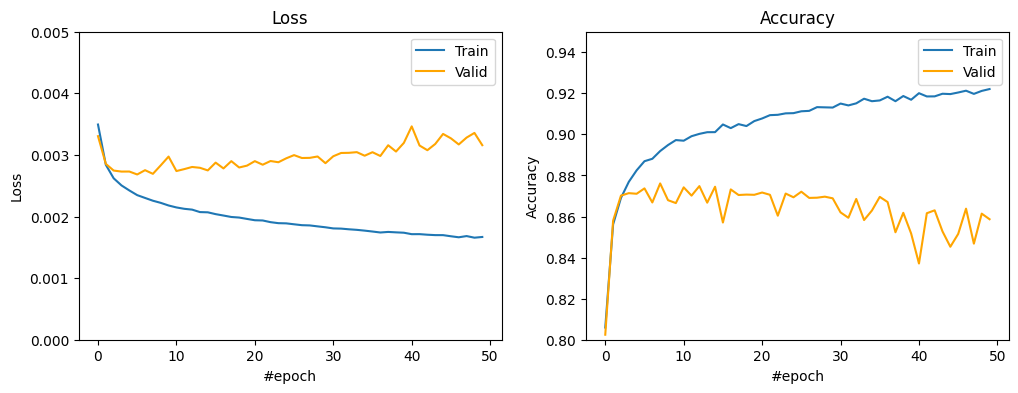

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].plot(train_losses, label='Train')
axes[0].plot(val_losses, color='orange', label='Valid')
axes[0].legend()
axes[0].set_xlabel('#epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].set_ylim(0, 0.005)

axes[1].plot(train_acc, label='Train')
axes[1].plot(val_acc, color='orange', label='Valid')
axes[1].legend()
axes[1].set_xlabel('#epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy')
axes[1].set_ylim(0.8, 0.95)

plt.show()

# 5.Prediction

In [ ]:
# Choose model gives the highest accuracy score
selected_idx = torch.argmax(torch.tensor(val_acc)).item()
selected_model = models[selected_idx].to('cpu')

In [ ]:
selected_model

TextClassificationModel(
  (embedding): EmbeddingBag(10000, 256, mode='mean')
  (linear): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
def predict(sentence):
  with torch.no_grad():
    encoded_sentence = torch.tensor(vocabulary(tokenizer(sentence)))
    result = selected_model(encoded_sentence, torch.tensor([0]))
    return torch.argmax(result).item()

In [ ]:
test_sen = test_df_vi['processed_sentence'][0]
test_label = test_df_vi['label'][0]
print('Sentence: \n', test_sen)
print(f'Groundtruth: {test_label}')
print(f'Prediction:  {predict(test_sen)}')

Sentence: 
 nhàhàng này có view chắc đẹp nhất aeonmallbìnhdương rồi nhìn ra đạilộ kiểu cổtrang của nhật nữa thahồ check in haha đồăn nhiều qtqd thấy thương mấy cô bé phụcvụ luôn mà lức nào cũng cười hỏi mình có cần gì ko đôikhi còn nhớ cả nướcchấm mình thích dùng kèm với gì luôn best service nhàhàng luôn có những chuong trình k mãi hấpdẫn và hơi độc mà mình thấy giá buffet ở đây cókhi chỉ có kset chỉmỗitội mới quá nên ít ai ghé thử toàn đi mấy nhàhàng sang chảnh mà đồăn cũng bìnhthường service tồi hehe em này được list vàosổ rồi nhé
Groundtruth: 1
Prediction:  1


Evaluation on Test set

In [ ]:
pred_ls, label_ls = [], []
for idx, row in test_df_vi.iterrows():
  sentence = row['processed_sentence']
  label = row['label']
  pred = predict(sentence)
  pred_ls.append(pred)
  label_ls.append(label)

test_acc = (torch.tensor(pred_ls) == torch.tensor(label_ls)).sum().item() / len(label_ls)

In [ ]:
print('Evaluation:')
print(f'  - Training set:     {train_acc[selected_idx]*100:.2f}%')
print(f'  - Validation set:   {val_acc[selected_idx]*100:.2f}%')
print(f'  - Test set:         {test_acc*100:.2f}%')

Evaluation:
  - Training set:     89.19%
  - Validation set:   87.61%
  - Test set:         86.47%


# 6.Other vector representation techniques

## 6.1. BoW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np

In [ ]:
train_labels = np.array(train_df_vi['label'])
val_labels = np.array(val_df_vi['label'])
test_labels = np.array(test_df_vi['label'])

vocab_size = 10000
vectorizer = CountVectorizer(max_features=vocab_size)

train_sequence = vectorizer.fit_transform(train_df_vi['processed_sentence'])
val_sequence = vectorizer.transform(val_df_vi['processed_sentence'])
test_sequence = vectorizer.transform(test_df_vi['processed_sentence'])

In [ ]:
bow_cls = LogisticRegression()
bow_cls.fit(train_sequence, train_labels)
train_acc_bow = bow_cls.score(train_sequence, train_labels)
val_acc_bow = bow_cls.score(val_sequence, val_labels)
test_acc_bow = bow_cls.score(test_sequence, test_labels)

In [ ]:
print('BoW Evaluation:')
print(f'  - Training set:       {train_acc_bow*100:.2f}%')
print(f'  - Validation set:     {val_acc_bow*100:.2f}%')
print(f'  - Test set:           {test_acc_bow*100:.2f}%')

BoW Evaluation:
  - Training set:       94.24%
  - Validation set:     87.36%
  - Test set:           87.94%


## 6.2. TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=vocab_size)
train_tfidf = tfidf_vectorizer.fit_transform(train_df_vi['processed_sentence'])
val_tfidf = tfidf_vectorizer.transform(val_df_vi['processed_sentence'])
test_tfidf = tfidf_vectorizer.transform(test_df_vi['processed_sentence'])

tfidf_cls = LogisticRegression()
tfidf_cls.fit(train_tfidf, train_labels)

train_acc_tfidf = tfidf_cls.score(train_tfidf, train_labels)
val_acc_tfidf = tfidf_cls.score(val_tfidf, val_labels)
test_acc_tfidf = tfidf_cls.score(test_tfidf, test_labels)

In [ ]:
print('TF-IDF Evaluation:')
print(f'  - Training set:       {train_acc_tfidf*100:.2f}%')
print(f'  - Validation set:     {val_acc_tfidf*100:.2f}%')
print(f'  - Test set:           {test_acc_tfidf*100:.2f}%')

TF-IDF Evaluation:
  - Training set:       91.05%
  - Validation set:     88.54%
  - Test set:           88.74%


## 6.3. Summary

In [ ]:
import pandas as pd
eval_summary = {'name': ['MLP with EmbeddingBag','BoW','TF-IDF'],
                'train_score': [train_acc[selected_idx]*100, train_acc_bow*100, train_acc_tfidf*100],
                'validation_score': [val_acc[selected_idx]*100, val_acc_bow*100, val_acc_tfidf*100],
                'test_score': [test_acc*100, test_acc_bow*100, test_acc_tfidf*100]}

eval_summary = pd.DataFrame(eval_summary)
eval_summary

,name,train_score,validation_score,test_score
0,MLP with EmbeddingBag,89.188189,87.612136,86.471774
1,BoW,94.239306,87.360145,87.943548
2,TF-IDF,91.054614,88.539462,88.739919
